# Chapter 2. Spherical harmonics
See also M-Sec. 4.1. and S-Sec. 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import polarsh as psh
from IPython.display import display
from utils import imshow, plot_text_only

## 2.1. SH Basis functions
`ScalarField.from_SH_upto(level, sphG, sh_type)` constructs SH basis functions $Y_{lm}$ up to $0\le l < \mathtt{level}$. Note that since $Y_{lm}$ is defined for indices within $\left|m\right|\le l$, the we obtain $\mathtt{level}^2$ basis functions here. (M-Eqs. (1) and (12), S-Prop. 2.1, S-Def. 2.7.)

In [2]:
sphG = psh.SphereGridCube(16)
level = 4

scalF_SHupto_R = psh.ScalarField.from_SH_upto(level, sphG, psh.SHType.REAL) # Using `psh.SHType.COMP` instead of `psh.SHType.REAL` produces the complex SH
print(scalF_SHupto_R)
assert scalF_SHupto_R.shape_chan == (level**2, )

ScalarField[
  dom_type = <DomType.UNI: 0>,
  fval.shape = [g:6, 16, 16 | c:16,],
]


`polarsh` supports various functions to handle SH indices $l$ and $m$.

Here, argument names follows the following convention:
* `level: int` (must not be an array)
* `lms: ArrayLike[dtype=int]`
* `level2lms(level, dom_type, unpack=False)`
    * Parameters:
        * `level: int`

In [3]:
level_curr = 3
N = psh.level2num(level_curr, psh.DomType.UNI)
lm = psh.level2lms(level_curr, psh.DomType.UNI) # `lms` named after indices `l`, `m`, and the English plural suffix '-s'.
print(f"{N = }")
print(lm)
assert lm.shape == (N, 2) # `2` for DomType.UNI

l = lm[:, 0]; m = lm[:, 1]
assert (np.abs(m) <= l).all()

l2, m2 = psh.level2lms(level_curr, psh.DomType.UNI, unstack=True) # `unstack=True` makes the result transposed
assert np.array_equal(l, l2) and np.array_equal(m, m2)

N = 9
[[ 0  0]
 [ 1 -1]
 [ 1  0]
 [ 1  1]
 [ 2 -2]
 [ 2 -1]
 [ 2  0]
 [ 2  1]
 [ 2  2]]


(Real) spherical harmonics $Y_{lm}^R:\hat{\mathbb{S}}^2 \to \mathbb R$

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='1000px')
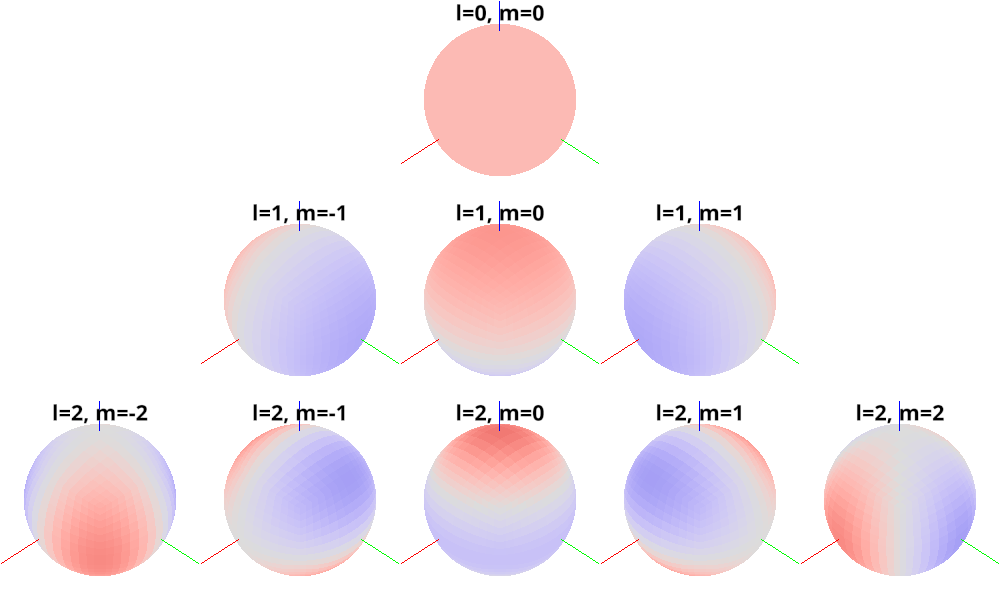

In [4]:
# ---------- Parameters ----------
level_show = 3 # any number in `level_show <= level`

# ---------- Main ----------
with psh.visualize_layout(level_show, 2*level_show-1, figsize=(1000, 600)):
    for i, (l,m) in enumerate(psh.level2lms(level_show, psh.DomType.UNI)):
        if m == -l:
            psh.visualize_layout.skip(level_show-l-1)
        scalF_SHupto_R.chan[i].visualize(title=f"{l=}, {m=}", help=False)
        if m == l:
            psh.visualize_layout.skip(level_show-l-1)

## 2.2. Converting a scalar field to a SH coefficient vector
A scalar field $f:\hat{\mathbb{S}}^2 \to \mathbb{R}$ in an object `scalF`

RFBOutputContext()

[Keyboard interface]
V: texture/point cloud mode
A: hide/show global axes


CanvasBackend(css_height='500px')
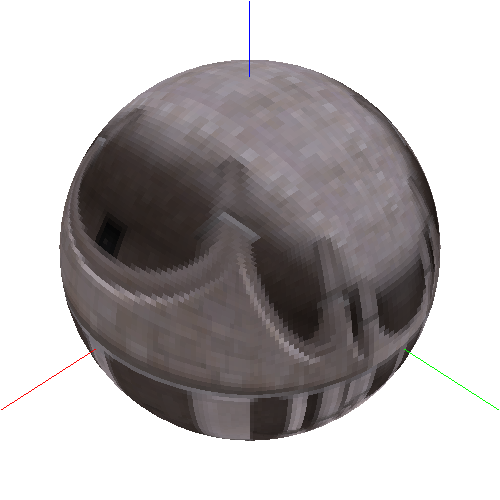

In [5]:
scalF = psh.ScalarField.from_cubeimage(psh.data_dir/"sponza_64_s0.exr")
scalF.visualize()

Frequency domain information of the scalar field $f$ (`scalF`) can be characterized by the *SH coefficient vector* $\mathbf{f}=\left[\mathrm f_{00}, \mathrm f_{1,-1}, \mathrm f_{10}, \mathrm f_{11}, \cdots \right]$. It can be evaluated by the `scalF.SHCoeff()` method which resturns an instance of the `SHVec` class.

`SHVec` instance is characterized by the `.coeff: np.ndarray` attribute.

In [6]:
level = 5
shv = scalF.SHCoeff(level, psh.SHType.REAL)
print(f"{type(shv) = }")
print(shv)
print(f"{shv.coeff.shape = }")

type(shv) = <class 'polarsh.SHCoeff.SHVec'>
SHVec[c: 3, | N: 25 (SCALAR)][
  level = 5,
  cod_type = <CodType.SCALAR: 1>,
  sh_type = <SHType.REAL: 0>,
  coeff.shape = (3, 25),
  coeff.dtype = float64,
]
shv.coeff.shape = (3, 25)


See `SHVec` instance using `.tabulate()` or `.matshow()`

SHVec.coeff[0,:]
----------------
l,m        value
-----  ---------
0,0     1.39e+00
1,-1   -2.85e-03
1,0    -1.34e+00
1,1     1.89e-04
2,-2    2.02e-05
2,-1    3.28e-03
2,0     1.47e+00
2,1    -9.61e-04
2,2    -3.78e-01
3,-3    2.29e-03
3,-2   -8.65e-06
3,-1   -1.08e-03
3,0    -9.64e-01
3,1     2.43e-04
3,2     6.15e-01
3,3    -3.87e-04
4,-4   -6.77e-05
4,-3   -3.12e-03
4,-2    4.79e-06
4,-1   -1.73e-03
4,0     6.93e-01
4,1    -6.70e-04
4,2    -9.04e-01
4,3     5.40e-04
4,4     1.13e-01


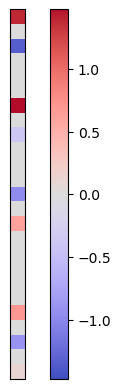

In [7]:
print(shv.tabulate(0)) # `0` to specify a channel (red)
shv.matshow(0); # `0` to specify a channel (red)

Here, `shv.coeff` consists of:
$$\tag{M-3 and S-35, using $Y_{lm}^R$ instead of $Y_{lm}$}
\mathrm{f} _{lm}={\left\langle Y_{lm}^R, f \right\rangle}_{\mathcal{F}}.
$$

Let's check this equation. Recall that $f$ indicates `scalF`. For fixed $l$ and $m$, which are determined using `i` in the following code, `Y_{lm}^R` is represented by `scalF_SHi`.

In [8]:
scalF_SH = psh.ScalarField.from_SH_upto(level, scalF.SphGrid, psh.SHType.REAL)

The inner product of two spherical functions is implemented in `ScalarField.inner()`, which is the same as an integral.
We also check $\mathrm{f} _{lm}={\left\langle Y_{lm}^R, f \right\rangle}_{\mathcal{F}}$.

In [9]:
for idx, (l,m) in enumerate(psh.level2lms(level, psh.DomType.UNI)):
    scalF_SHi = scalF_SH.chan[idx]
    inner = scalF_SHi.inner(scalF)
    if idx == 0:
        print(f"{scalF.SphGrid.weight().shape = }")
        print(f"{scalF.fval.shape = }")
        print(f"{scalF_SHi.fval.shape = }")
    # Check definition of the inner product of scalar fields
    assert np.allclose(inner, (scalF_SHi.fval.conj()[..., None] * scalF.fval * scalF.SphGrid.weight()[..., None]).sum((0, 1, 2)))
    # Check definition of the SH coefficient vector
    assert np.allclose(shv.coeff[:, idx], scalF_SHi.inner(scalF))

scalF.SphGrid.weight().shape = (6, 64, 64)
scalF.fval.shape = (6, 64, 64, 3)
scalF_SHi.fval.shape = (6, 64, 64)


## 2.3. Reconstructing back into angular (directional) domain
Band-limited scalar field from finite SH coefficients.

RFBOutputContext()

CanvasBackend(css_height='500px')
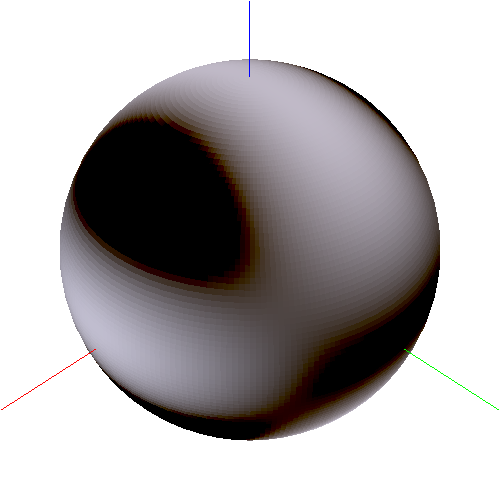

In [10]:
sphG_er = psh.SphereGridEquirect(128, 256)
scalF_recon = psh.ScalarField.from_SHCoeff(shv, sphG_er)
scalF_recon.visualize(help=False)

The fact that SH are a basis of the space scalar fields implies that:
$$
f = \mathrm{f}_{00}Y_{00}^R + \mathrm{f}_{1,-1}Y_{1,-1}^R + \mathrm{f}_{10}Y_{10}^R + \mathrm{f}_{11}Y_{11}^R + \cdots
$$
It can be checked as follows:

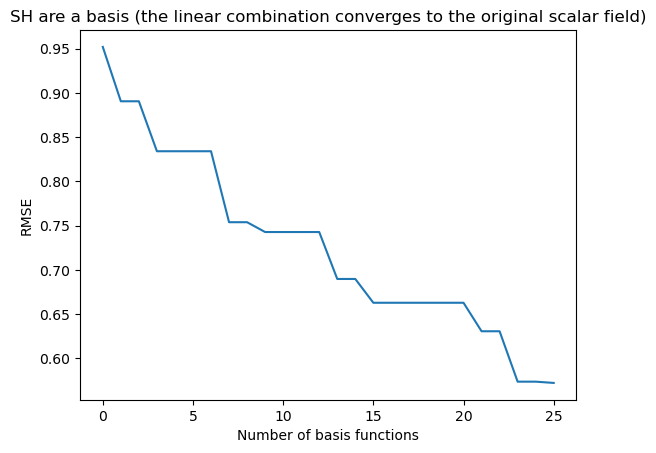

In [11]:
scalF_accum = psh.ScalarField.zeros_like(scalF)

loss = [psh.rms(scalF.fval)]
for idx, (l,m) in enumerate(psh.level2lms(level, psh.DomType.UNI)):
    scalF_accum += scalF_SH.chan[idx].chan * shv.coeff[:, idx]
    loss.append(psh.rms((scalF - scalF_accum).fval))

plt.plot(range(idx+2), loss)
plt.xlabel("Number of basis functions"); plt.ylabel("RMSE")
plt.title("SH are a basis (the linear combination converges to the original scalar field)");

## 2.4. SH coefficient matrices and rotation invariance

In [12]:
# ---------- Paramters ----------
rotvec = [np.pi/2, 0, 0]
shm = psh.SHMat.from_rotation(rotvec, level, psh.CodType.SCALAR, psh.SHType.REAL)
print(shm)
print("\n[Tabulate]:")
print(shm.cut(4).tabulate(())) # `.cut(4)` cuts coefficients in `shm` up to 0 <= l < 4

SHMat[c:  | N: 25, 25 (SCALAR)][
  level = 5,
  dom_type = <DomType.UNI: 0>,
  cod_type = <CodType.SCALAR: 1>,
  sh_type = <SHType.REAL: 0>,
  coeff.shape = (25, 25),
  coeff.dtype = float64,
]

[Tabulate]:
SHMat.coeff[(),:,:]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
l,m         0,0       1,-1       1,0       1,1       2,-2       2,-1        2,0        2,1        2,2       3,-3       3,-2       3,-1        3,0        3,1        3,2        3,3
-----  --------  ---------  --------  --------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------
0,0    1.00e+00   0.00e+00  0.00e+00  0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00
1,-1   0.00e+00   0.00e+00  1.00e+00  0.00e+00   0.00e+00

Each element if the coefficient matrix is:
$$
\delta_{ll'}D_{mm'}^{l,R}\left(\vec R\right) = \left\langle Y_{lm}^R, \vec R_{\mathcal F}\left[Y_{l'm'}^R\right] \right\rangle_{\mathcal F}
$$
Note that all errors in the loop will converge to zero as the grid resolution of `scalF.SphGrid` increases.
> [Implementation tip]
> 
> Note that `scalF_SH_rot` and `scalF_SH.apply_rotation(rotvec)` indicate the identical scalar functions in theory. However they have different attribute `.SphGrid`: `scalF.SphGrid` and `scalF.SphGrid.apply_rotation(rotvec)`, resp. To make `.inner` method work (without resampling/nereast neighbor search between two `SphereGrid` objects), we are using the former one.

In [13]:
scalF_SH = psh.ScalarField.from_SH_upto(level, scalF.SphGrid, psh.SHType.REAL)
scalF_SH_rot = psh.ScalarField.from_SH_upto(level, scalF.SphGrid, psh.SHType.REAL, rotated=rotvec)
N = psh.level2num(level, psh.DomType.UNI) # number of pairs of (l, m)
for lmo in range(N): # rows
    for lmi in range(N): # columns
        coeff_curr = shm.coeff[lmo, lmi]
        inner_curr = scalF_SH.chan[lmo].inner(scalF_SH_rot.chan[lmi])
        assert np.allclose(coeff_curr, inner_curr, atol=1.5e-4) # As the resolution of `scalF.SphGrid` increases, the tolerance `1.5e-4` con converge to zero
print("Clear!")

Clear!


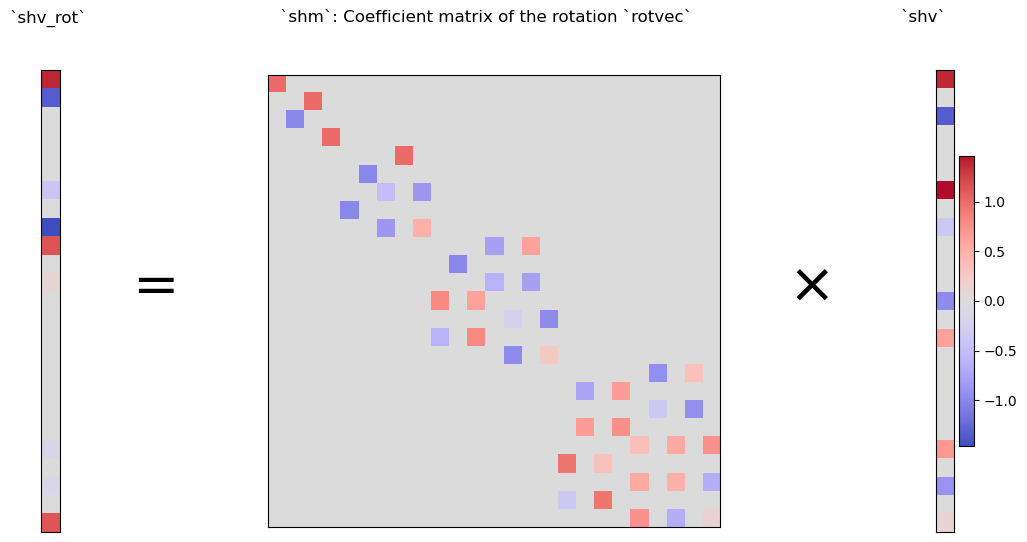

In [14]:
# ---------- Set a layout for visualization ----------
fig = plt.figure(figsize=(10, 6))
subfigs = fig.subfigures(1, 5, width_ratios=[1.5, 1, 7, 1, 1.5])
norm = mcolors.CenteredNorm()

# ---------- Compute coefficient rotation ----------
shv_rot = rotvec @ shv
assert shv_rot.allclose(shm @ shv)

# ---------- Show data ----------
shv_rot.matshow(0, title="`shv_rot`", long=True, norm=norm, colorbar=False, fig=subfigs[0])
plot_text_only(subfigs[1], "$=$")
shm.matshow(title="`shm`: Coefficient matrix of the rotation `rotvec`", norm=norm, colorbar=False, fig=subfigs[2])
plot_text_only(subfigs[3], r"$\times$")
shv.matshow(0, title="`shv`", long=True, norm=norm, fig=subfigs[4]);

RFBOutputContext()

[Keyboard interface]
V: texture/point cloud mode
A: hide/show global axes


CanvasBackend(css_height='400px', css_width='800px')
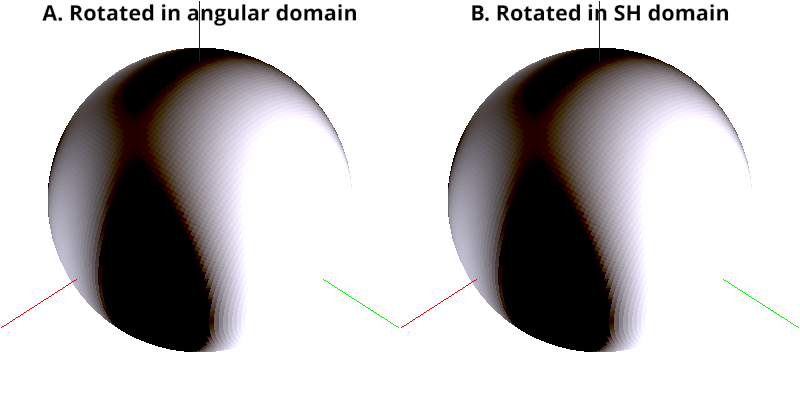

In [15]:
scalF_recon_rot = scalF_recon.apply_rotation(rotvec)
scalF_rot_recon = psh.ScalarField.from_SHCoeff(shv_rot, scalF_recon_rot.SphGrid)
titles = ["A. Rotated in angular domain", "B. Rotated in SH domain", "Difference"]

with psh.visualize_layout(1, 2, figsize=(800, 400)):
    scalF_recon_rot.visualize(title=titles[0])
    scalF_rot_recon.visualize(title=titles[1], help=False)

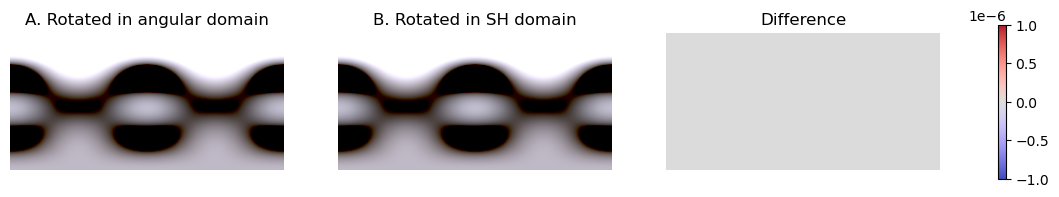

In [16]:
scalF_list = [scalF_recon_rot, scalF_rot_recon, scalF_recon_rot-scalF_rot_recon]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (ax, scalF) in enumerate(zip(axes, scalF_list)):
    im = imshow(ax, scalF.fval[::-1], i==2, title=titles[i], norm=mcolors.Normalize(-1e-6, 1e-6))
    # For [::-1], see S-Figure 8.
plt.colorbar(im, shrink=0.4, ax=axes);

## 2.5. Spherical convolution in the SH domain
Recall the spherical convolution we covered in [Chapter 1.4](1_spherical_functions.ipynb).

RFBOutputContext()

CanvasBackend(css_height='500px')
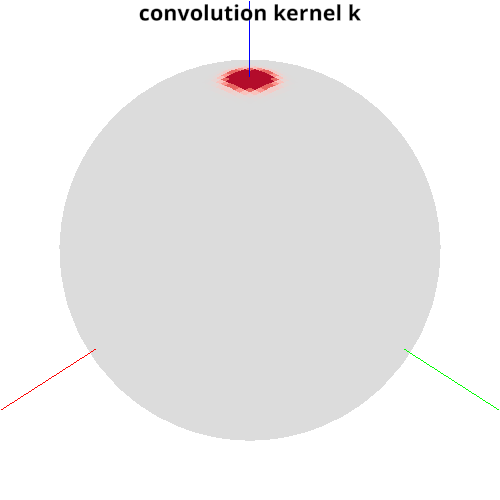

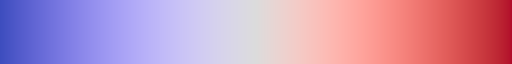

In [17]:
def func_kernel(theta):
    sigma = 0.05
    mu = 0.0
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (theta - mu)**2 / (2 * sigma**2))
kernel = psh.ScalarConvKernel(func_kernel) # $k$ or $k*$

# As a `ScalarField` object
sphG = psh.SphereGridCube(64) # any instance of `SphereGrid` you want is okay
z_g = [0, 0, 1]
kernel_scalF = kernel.apply_delta(z_g, sphG)
display(kernel_scalF.visualize(title="convolution kernel k", help=False))
psh.pltcmap_diverge # show colorbar

### SH convolution coefficient
The SH coefficients for the convolution kernel (convolution coefficients) is obtained by
$$
\mathrm{k}_{l0} \coloneqq \left\langle Y_{l0}^R, k \right\rangle_{\mathcal F} = \left\langle Y_{l0}, k \right\rangle_{\mathcal F},
$$
where $k$ is considered as a scalar field. It can be computed by the following method:

`psh.ScalarConvKernel.SHCoeff(level, n_sample=None)`
* `level`: Compute the coefficients $\mathrm{k}_{l0}$ up to $0\le l <$`level`
* `n_sample` [`int`]: The number of evenly-spaced samples for the zenith $\theta\in\left[0,\pi\right]$ where the inner product integral of $\mathrm{k}_{lm}$ will be evaluated. Note that while the inner product integral of `ScalarField.SHCoeff(level)` is computed on a finite spherical points characterized by the attribute `ScalarField.SphGrid: SphereGrid`, we only need to specify such spherical points on the half great circle of $\phi=0$ for `ScalarConvKernel` due to its azimuthal symmetry. As default, `n_sample` will be a sufficiently large number to compute coefficients up to given `level`.
* Return [`psh.SHConv`]: SH coefficients for the (scalar) convolution kernel

The resulting instance of `psh.SHConv` is mainly characterized by following values
* `coeff_s2s()` [`np.ndarray`]: SH coeffcients of the convolution kernel as a scalar field.
* `coeff_s2v()` [`np.ndarray`]: `None` for scalar convolution kernel. It will be explained in [Chapter 6. Polarized Spherical Convolution](./6_polarized_spherical_convolution.ipynb)
* `coeff_v2s()` [`np.ndarray`]: `None` for scalar convolution kernel. It will be explained in [Chapter 6. Polarized Spherical Convolution](./6_polarized_spherical_convolution.ipynb)
* `coeff_v2va()` [`np.ndarray`]: `None` for scalar convolution kernel. It will be explained in [Chapter 6. Polarized Spherical Convolution](./6_polarized_spherical_convolution.ipynb)
* `coeff_v2vb()` [`np.ndarray`]: `None` for scalar convolution kernel. It will be explained in [Chapter 6. Polarized Spherical Convolution](./6_polarized_spherical_convolution.ipynb)

In [18]:
level = 50
with psh.Tictoc("Convolution kernel to its SH coefficients: %.4f sec."):
    shConv: psh.SHConv = kernel.SHCoeff(level)
print(f"\n{shConv = }")
print(f"{shConv.coeff_s2s().shape = }")
print(f"{shConv.coeff_s2s()[:10].shape = }")

Convolution kernel to its SH coefficients: 1.9599 sec.

shConv = SHConv[c:  | L: 50 (SCALAR)][
  level = 50,
  cod_type = <CodType.SCALAR: 1>,
  weighted = False,
  s2s[50,] float64,
]
shConv.coeff_s2s().shape = (50,)
shConv.coeff_s2s()[:10].shape = (10,)


Note that the SH convolution coefficients is identitcal to the SH coefficient vector of the kernel as a scalar field. Here, observe that $\mathrm{k}_{lm}=0$ whenever $m\ne 0$.

SH coefficient vector of the kernel as a scalar field: 7.8989 sec.


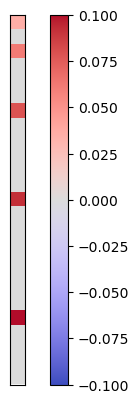

In [19]:
level_test = 5
with psh.Tictoc("SH coefficient vector of the kernel as a scalar field: %.4f sec."):
    shv = kernel.apply_delta(z_g, psh.SphereGridCube(512)).SHCoeff(level_test, "REAL") # "COMP" is okay

shv_from_SHConv = psh.SHVec.zeros_like(shv)
l, m = psh.level2lms(level_test, "UNI", True)
shv_from_SHConv.coeff[..., m==0] = shConv.coeff_s2s()[:level_test]

assert shv.allclose(shv_from_SHConv)
# Then it can be also visualized by `SHVec.matshow()`
color_norm = mcolors.Normalize(-0.1, 0.1)
shv.matshow(norm=color_norm);

### SH convolution (spherical convolution theorem)
Applying the convolution operation is done by:
$$\tag{M-11, S-78}
\mathrm{f}_{lm}' = \sqrt{\frac{4\pi}{2l+1}}\mathrm k_{l0}\mathrm{f}_{lm},
$$
where $f_{lm}'$ denotes the SH coefficient of $f'\coloneqq k*f$.

While it can be simply performed by `SHConv @ SHVec`, the computation process is more visible when `SHConv` is converted into `SHMat`.

shv = SHVec[c: 3, | N: 2500 (SCALAR)][
  level = 50,
  cod_type = <CodType.SCALAR: 1>,
  sh_type = <SHType.REAL: 0>,
  coeff.shape = (3, 2500),
  coeff.dtype = float64,
]
Spherical convolution in SH coefficients domain: 0.001000


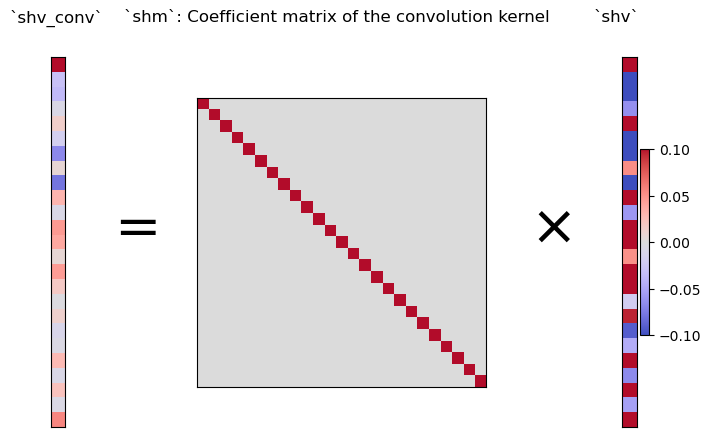

In [20]:
# Here we use a precomputed SH coefficient vector since level=100 requires long time to compute `ScalarField.SHCoeff()`.
shv = psh.SHVec.from_npz_file("./input/SHVec_bathroom_1024_L100.npz").cut(level=level, cod_type="SCALAR")
print(f"{shv = }")

with psh.Tictoc("Spherical convolution in SH coefficients domain: %.6f"):
    shv_conv: psh.SHVec = shConv @ shv

shm_conv = shConv.to_SHMat()
assert shv_conv.allclose(shm_conv @ shv)

# ---------- Visualize as matrix plots ----------
level_show = 5
cfg = dict(level_show=level_show, norm=color_norm)
subfigs = plt.figure().subfigures(1, 5, width_ratios=[1.5, 1, 7, 1, 1.5])
shv_conv.matshow(0, **cfg, title="`shv_conv`", colorbar=False, fig=subfigs[0])
plot_text_only(subfigs[1], "$=$")
shm_conv.matshow(**cfg, title="`shm`: Coefficient matrix of the convolution kernel", colorbar=False, fig=subfigs[2])
plot_text_only(subfigs[3], r"$\times$")
shv.matshow(0, **cfg, title="`shv`", fig=subfigs[4]);

Note the elementwise product of $\sqrt{\frac{4\pi}{2l+1}}\mathrm k_{l0}$ and $\mathrm{f}_{lm}$ in Eqs. (M-11, S-78) above is equivalent to the product of the diagonal matrix with elements $\sqrt{\frac{4\pi}{2l+1}}\mathrm k_{l0}$ and the vector with elements $\mathrm{f}_{lm}$.

In [21]:
print(shm_conv)

lo, mo = psh.level2lms(shm_conv.level, "UNI", unstack=True)
li, mi = lo[:,None], mo[:,None]
mask_diag = (li == lo) & (mi == mo)
assert np.array_equiv(shm_conv.coeff[~mask_diag], 0) # It is a diagonal matrix

assert np.allclose(shm_conv.coeff[mask_diag], np.sqrt(4*np.pi/(2*lo+1))*shConv.coeff_s2s()[lo])
assert np.allclose(shm_conv.coeff[mask_diag], shConv.coeff_s2s(weighted=True)[lo]) # `weight` in `SHConv` indicates $\sqrt{\frac{4\pi}{2l+1}}$
print("Clear!")

SHMat[c:  | N: 2500, 2500 (SCALAR)][
  level = 50,
  dom_type = <DomType.UNI: 0>,
  cod_type = <CodType.SCALAR: 1>,
  sh_type = <SHType.REAL: 0>,
  coeff.shape = (2500, 2500),
  coeff.dtype = float64,
]
Clear!


Now let's visualize the resulting spherical function and compare it with the angular-domain convolution.

Number of coefficients: 2500, Number of pixels: 2450
Reconstruct the convolved scalar field into the angular domain: 0.4838 sec.
Reconstruct the original scalar field into the angular domain: 0.4811 sec.
Spherical convolution in the angular domain: 0.2807


RFBOutputContext()

[Keyboard interface]
V: texture/point cloud mode
A: hide/show global axes
[Keyboard interface]
V: texture/point cloud mode
A: hide/show global axes


CanvasBackend(css_width='600px')
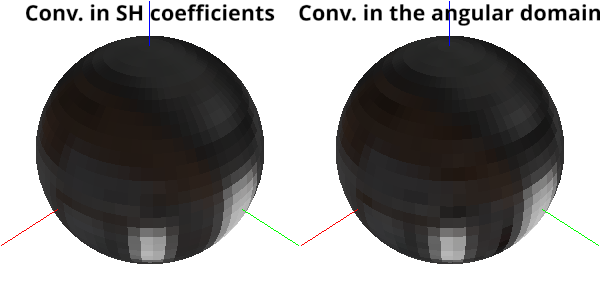

In [22]:
h = int(level / np.sqrt(2)); w = 2*h # image size which has the same number of pixels as the number of SH coefficients
print(f"Number of coefficients: {shv.N}, Number of pixels: {h*w}")

# ---------- Compute ----------
sphG = psh.SphereGridEquirect(h, w)
with psh.Tictoc("Reconstruct the convolved scalar field into the angular domain: %.4f sec."):
    scalF_conv_rec = psh.ScalarField.from_SHCoeff(shv_conv, sphG)
with psh.Tictoc("Reconstruct the original scalar field into the angular domain: %.4f sec."):
    scalF_rec = psh.ScalarField.from_SHCoeff(shv, sphG)
with psh.Tictoc("Spherical convolution in the angular domain: %.4f"):
    scalF_rec_conv = kernel.apply(scalF_rec)

# ---------- Visualize ----------
titles = ["Conv. in SH coefficients", "Conv. in the angular domain", "Difference"]
with psh.visualize_layout(1, 2, figsize=(600, 300)):
    scalF_conv_rec.visualize(title=titles[0])
    scalF_rec_conv.visualize(title=titles[1])

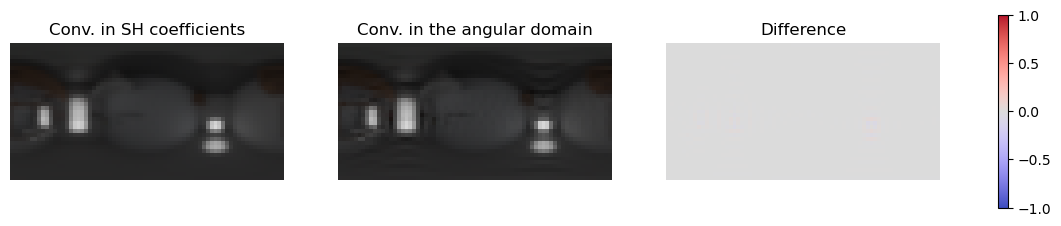

In [23]:
scalF_list = [scalF_conv_rec, scalF_rec_conv, scalF_conv_rec - scalF_rec_conv]
fig, axes = plt.subplots(1, 3, figsize=(15, 2.5))
for i, (ax, scalF, title) in enumerate(zip(axes, scalF_list, titles)):
    im = imshow(ax, scalF.fval, i==2, mcolors.Normalize(-1, 1), title)
plt.colorbar(im, ax=axes);